In [3]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from IPython.display import display

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Kent'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [5]:
def select_optimal_lv(calibration, validation):
    min_diff = float('inf')
    optimal_lv = 1
    max_lv = 10

    for lv in range(2, max_lv + 1):
        diff_cal = abs(calibration.loc[lv, 'r2_cal'] - calibration.loc[lv - 1, 'r2_cal'])
        diff_val = abs(validation.loc[lv, 'r2_cv'] - validation.loc[lv - 1, 'r2_cv'])
        
        avg_diff = (diff_cal + diff_val) / 2

        if avg_diff < min_diff:
            min_diff = avg_diff
            optimal_lv = lv

    return optimal_lv

def train_model(X_scaled, Y_scaled, max_lv=10):
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pca = PCA(n_components=lv)
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()

        # Calibração do modelo
        lin_reg.fit(X_pca, Y_scaled)
        predictions_train = lin_reg.predict(X_pca)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        Y_scaled_reshaped = Y_scaled.reshape(-1)
        predictions_train_reshaped = predictions_train.reshape(-1)

        # Calcular a correlação
        correlation_cal = np.corrcoef(Y_scaled_reshaped, predictions_train_reshaped)[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train_reshaped

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(lin_reg, X_pca, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        predictions_cv_reshaped = predictions_cv.reshape(-1)

        # Calcular a correlação para validação cruzada
        correlation_cv = np.corrcoef(Y_scaled_reshaped, predictions_cv_reshaped)[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv_reshaped
    
    # Selecionar o número ideal de componentes latentes baseado na menor variação de R²
    optimal_lv = select_optimal_lv(calibration, validation)
    
    pca = PCA(n_components=optimal_lv)
    X_pca = pca.fit_transform(X_scaled)
    lin_reg = LinearRegression()
    model = lin_reg.fit(X_pca, Y_scaled)

    return calibration, validation, optimal_lv, model, pca, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, pca, X_pred, y_pred, lv_number):
    #X_centered, _, _, _ = center_data(X_pred.iloc[:, 6:].values, y_pred.values)
    X_centered = X_pred.iloc[:, 7:].values
    X_pred_pca = pca.transform(X_centered)  # Transformar dados de teste com PCA
    
    pred = model.predict(X_pred_pca)
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_p', 'neg_root_mean_squared_error_p', 'explained_variance_p', 'correlation_p', 'rpearson_p', 'bias_p', 'sec_p'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred.flatten(), pred.flatten())[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred.flatten(), pred.flatten())[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[:, 0].tolist()
    
    return prediction, Y_predict


def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'R²': [r2_opt, r2_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'Offset': [offset_opt, offset_pred],
    'Slope': [slope_opt,slope_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
            transform=plt.gca().transAxes, verticalalignment='top')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    metrics_dict = pd.DataFrame({
    'Y': ['Validação'],
    'R²': [r2],
    'RMSE': [rmse],
    'Offset': [offset],
    'Slope': [slope]
    })
    
    return metrics_dict


def build_model(X_cal, Y_cal, X_val, Y_val):
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    calibration, validation, lv_num, model, pca, Y_values = train_model(X.iloc[:,7:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, pca, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    #display(chart_data)
    plot_infos_p = pred_plot(Y_predict)
    #display(Y_predict)
    plot_infos_df = plot_infos.copy()
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_df, plot_infos_p], ignore_index=True)
    
    
    
    return calibration, validation, Y_predict, plot_infos_pre

In [6]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_raw = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

In [7]:
print(df_raw_cal.columns)

Index([   'Amostra',    'FIRMEZA', 'MASSA SECA',       'BRIX',     'ACIDEZ',
              'AAC',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)


Número de componentes: 10


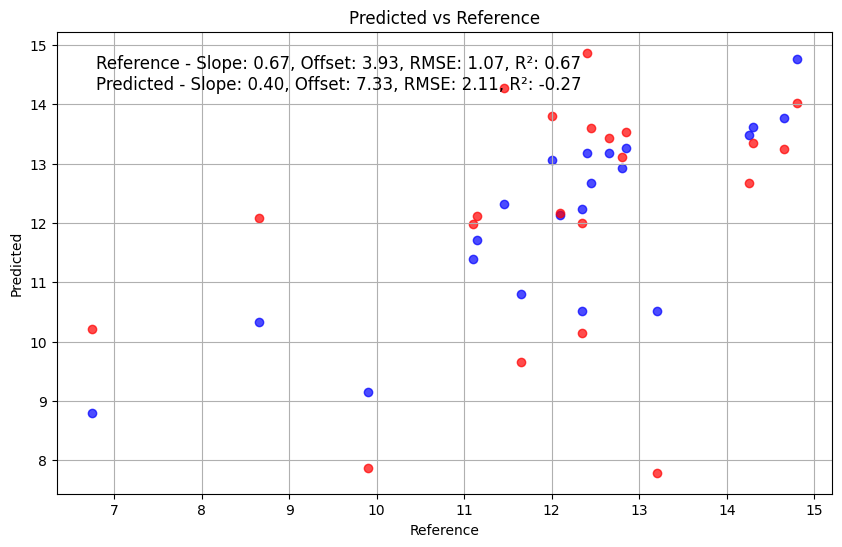

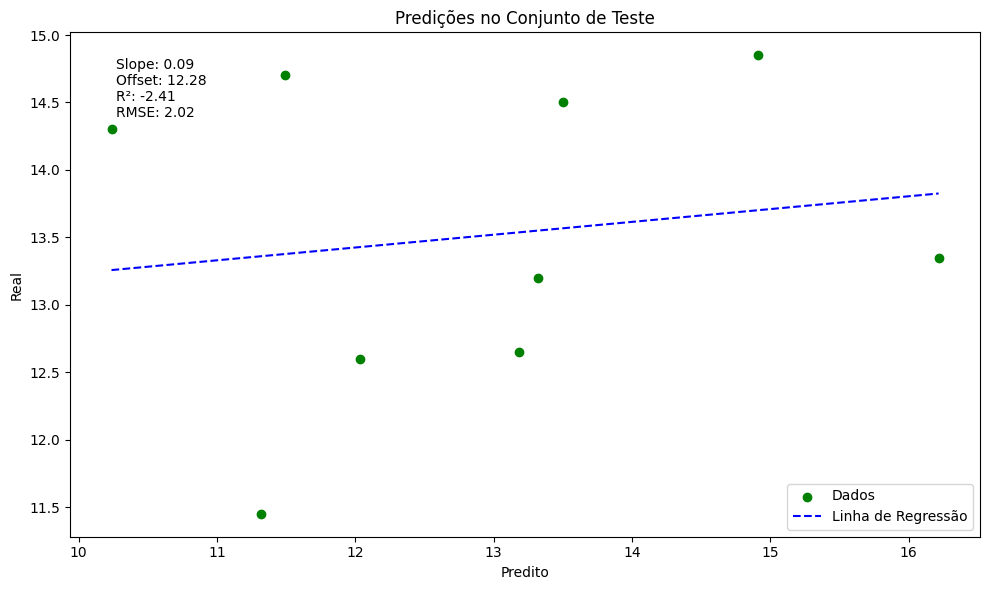

In [8]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['BRIX'], df_msc_val, df_msc_val['BRIX'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'BRIX')

Número de componentes: 8


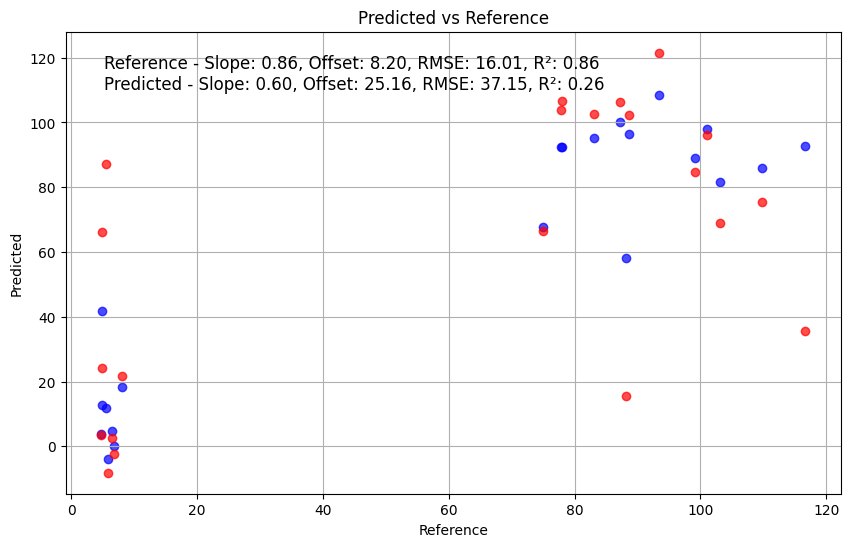

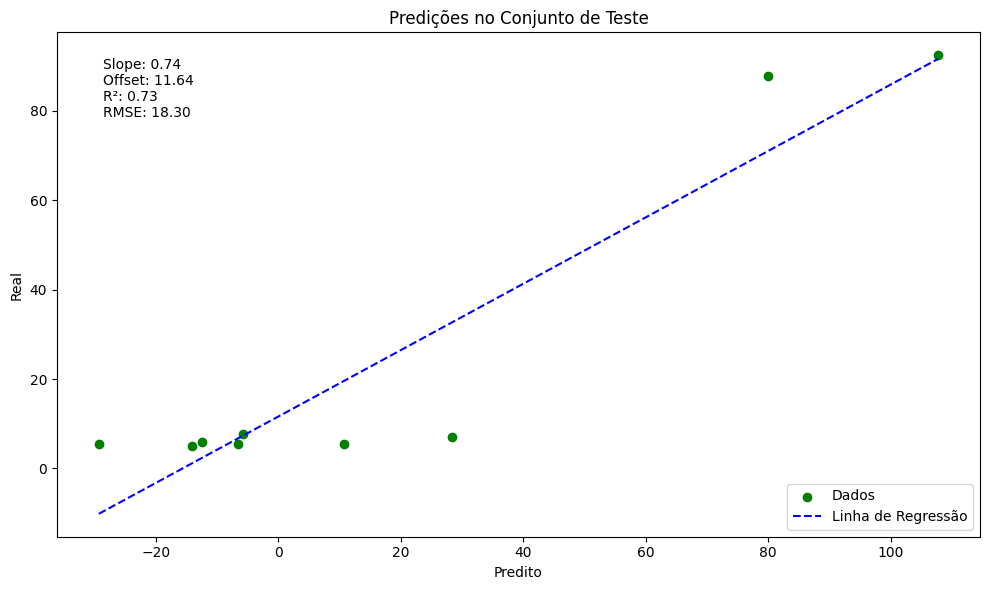

In [9]:
calibration_msc_firmeza, validation_msc_firmeza, Y_predict_msc_firmeza, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA'], df_msc_val, df_msc_val['FIRMEZA'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA')

Número de componentes: 2


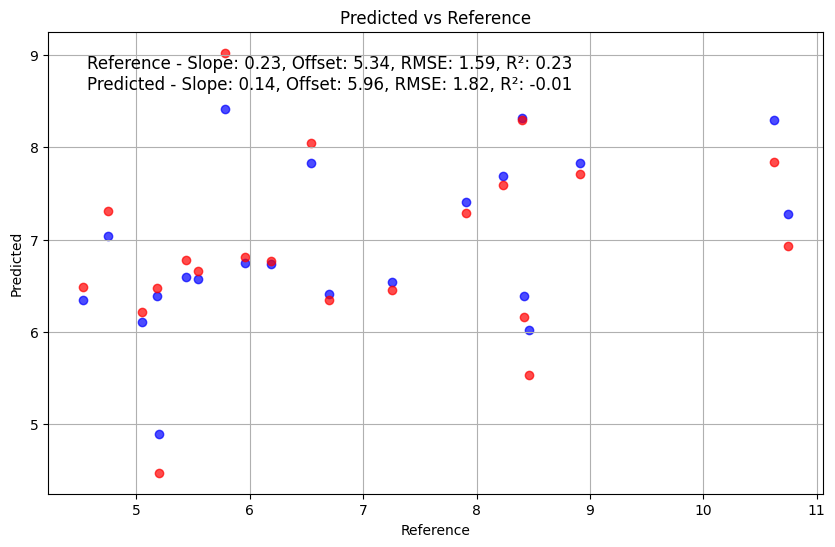

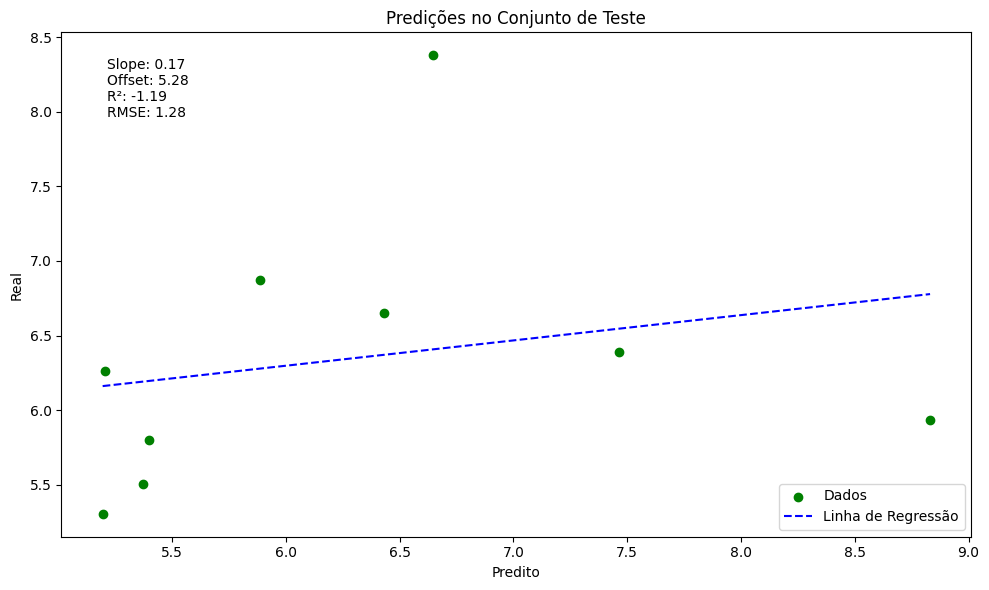

In [10]:
calibration_msc_aac, validation_msc_aac, Y_predict_msc_aac, plot_infos = build_model(df_msc_cal, df_msc_cal['AAC'], df_msc_val, df_msc_val['AAC'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AAC')

Número de componentes: 2


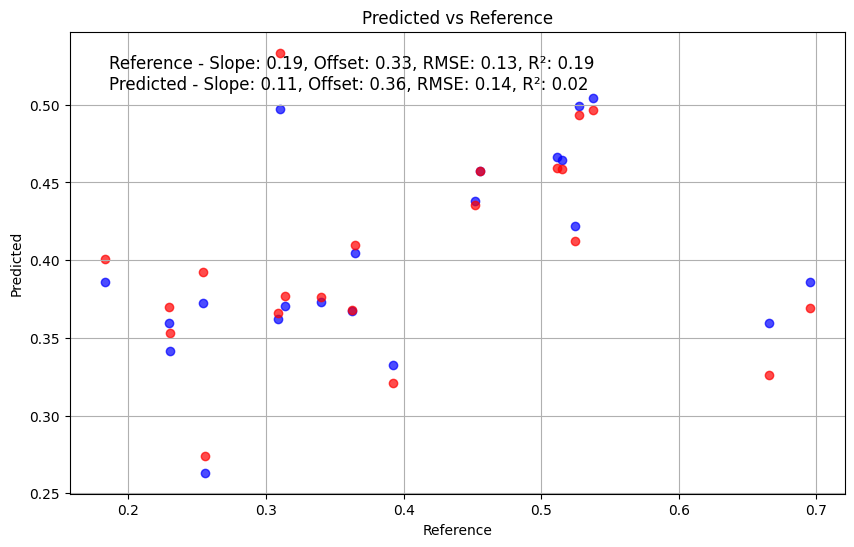

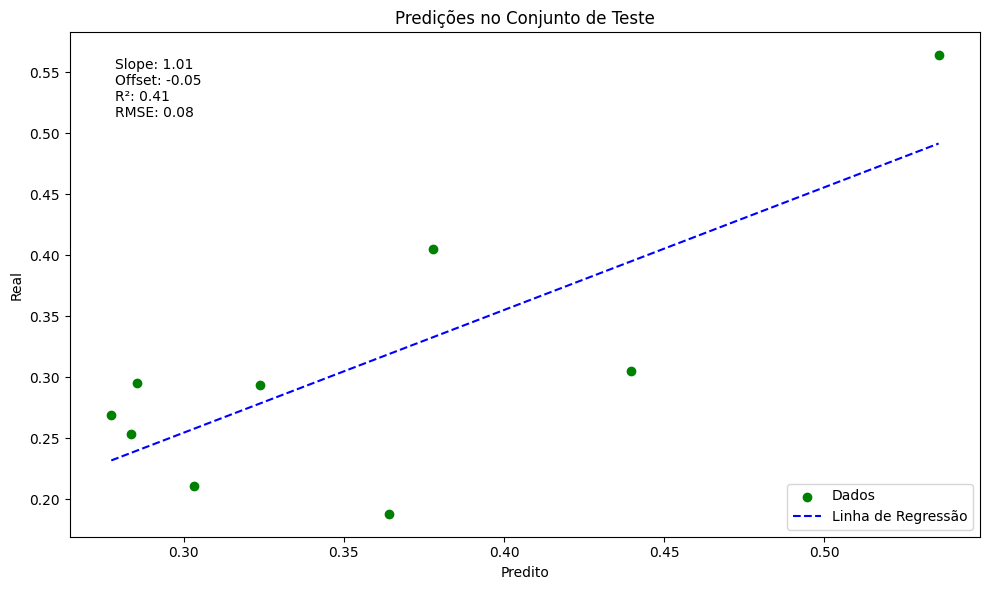

In [11]:
calibration_msc_att, validation_msc_att, Y_predict_msc_att, plot_infos = build_model(df_msc_cal, df_msc_cal['ACIDEZ'], df_msc_val, df_msc_val['ACIDEZ'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'ACIDEZ')

Número de componentes: 8


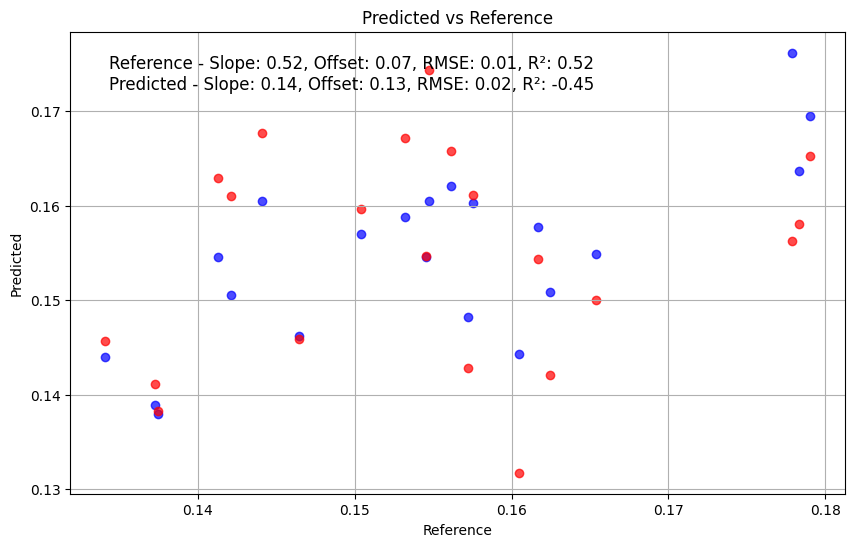

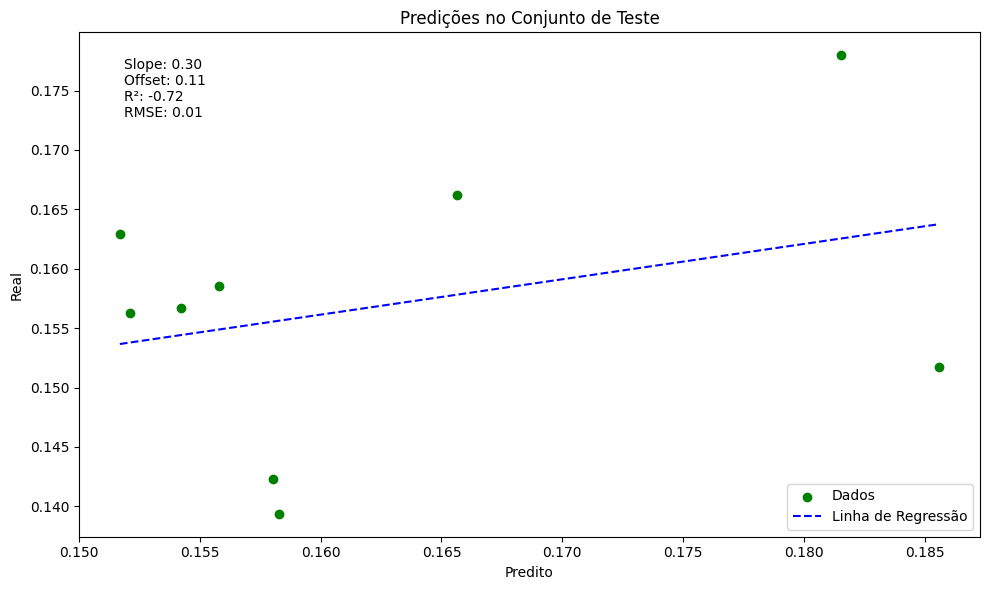

In [12]:
calibration_msc_ubs, validation_msc_ubs, Y_predict_msc_ubs, plot_infos = build_model(df_msc_cal, df_msc_cal['MASSA SECA'], df_msc_val, df_msc_val['MASSA SECA'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'MASSA SECA')

In [13]:
plot_infos_msc.to_excel('plot_infos_pcr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.674891,1.070740,3.929175,0.674891
1,BRIX,Predição,-0.265424,2.112456,7.326858,0.402113
2,BRIX,Validação,-2.409721,2.017994,12.284684,0.094983
3,FIRMEZA,Referência,0.862149,16.010958,8.195351,0.862149
4,FIRMEZA,Predição,0.257740,37.152629,25.157774,0.603299
5,FIRMEZA,Validação,0.725855,18.301575,11.637940,0.742194
6,AAC,Referência,0.230820,1.588669,5.340942,0.230820
7,AAC,Predição,-0.012528,1.822732,5.955395,0.138006
8,AAC,Validação,-1.194298,1.284592,5.280112,0.169619
9,ACIDEZ,Referência,0.189819,0.126823,0.325152,0.189819


Número de componentes: 5


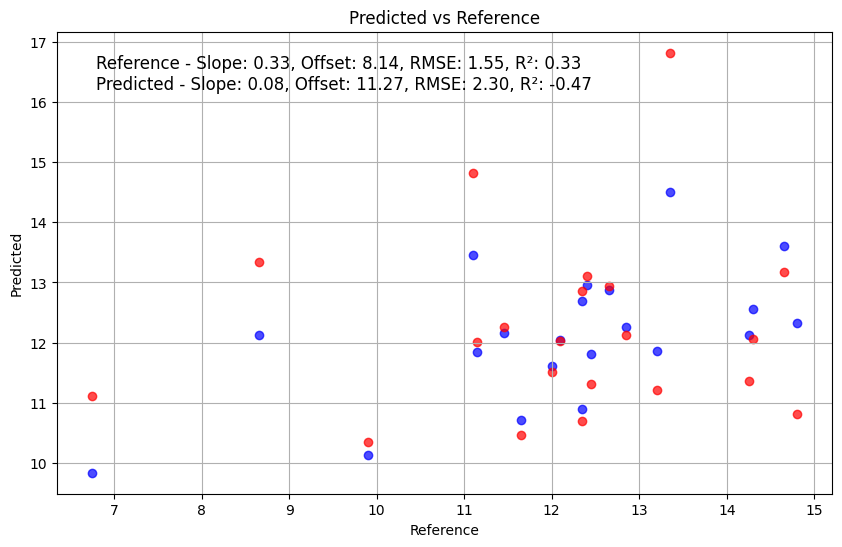

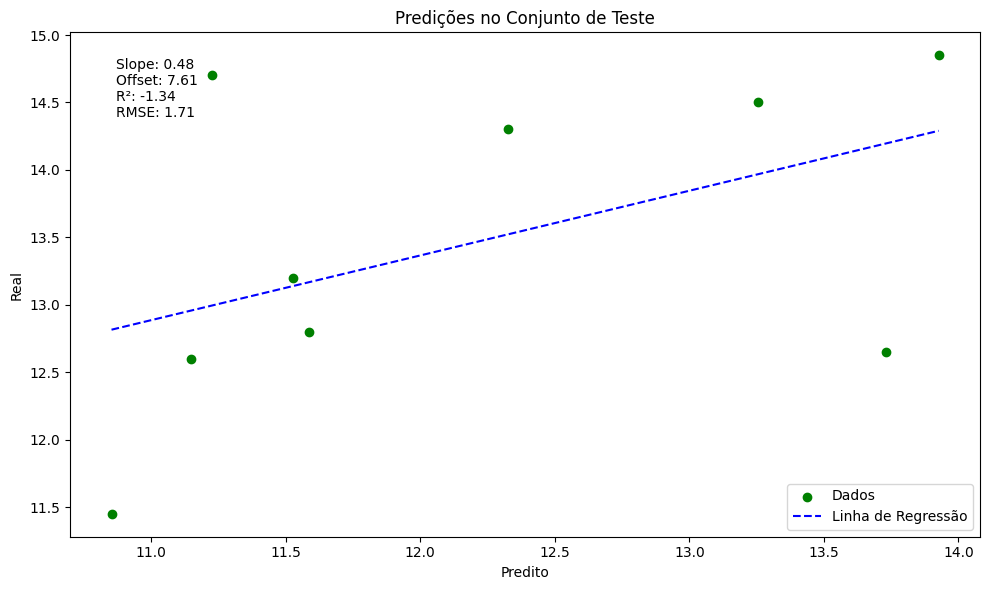

In [14]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['BRIX'], df_snv_val, df_snv_val['BRIX'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'BRIX')

Número de componentes: 7


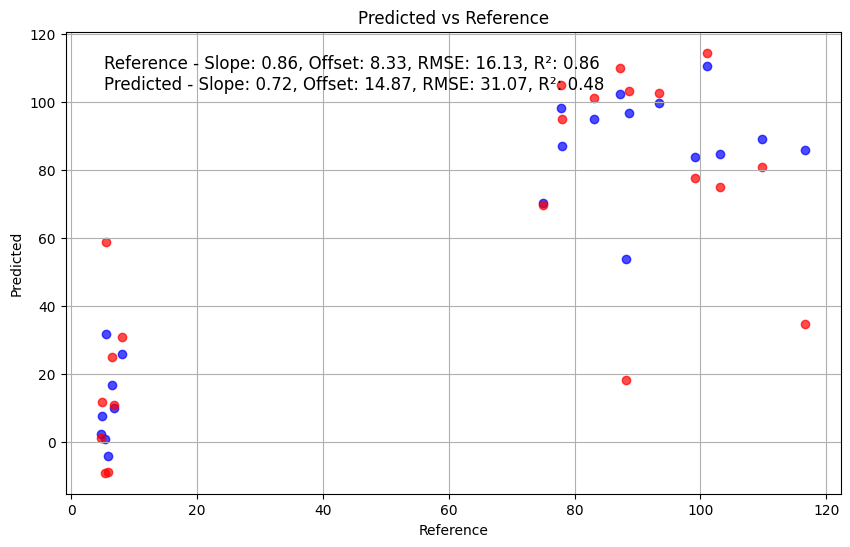

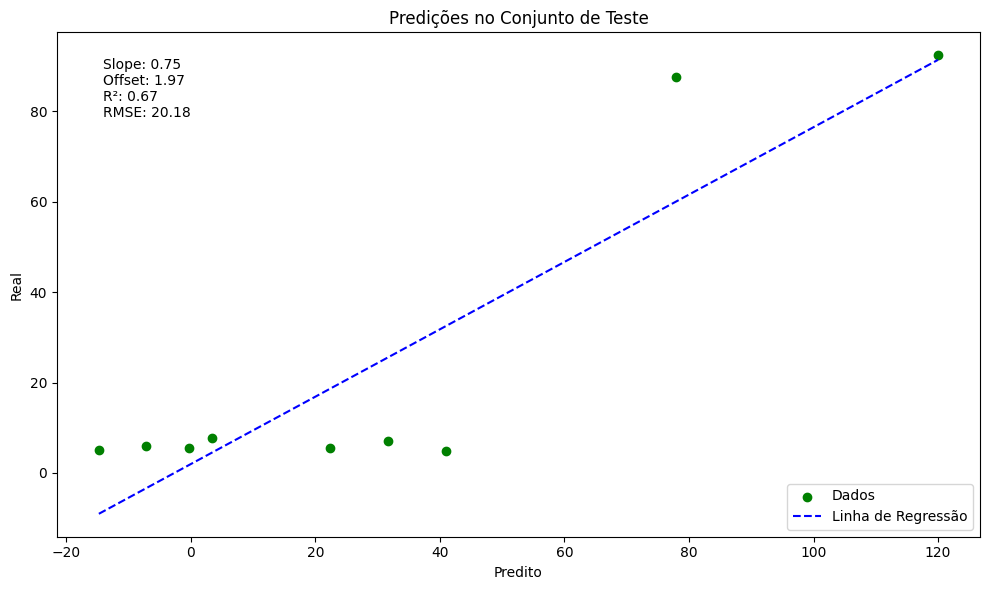

In [15]:
calibration_snv_firmeza, validation_snv_firmeza, Y_predict_snv_firmeza, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA'], df_snv_val, df_snv_val['FIRMEZA'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA')

Número de componentes: 2


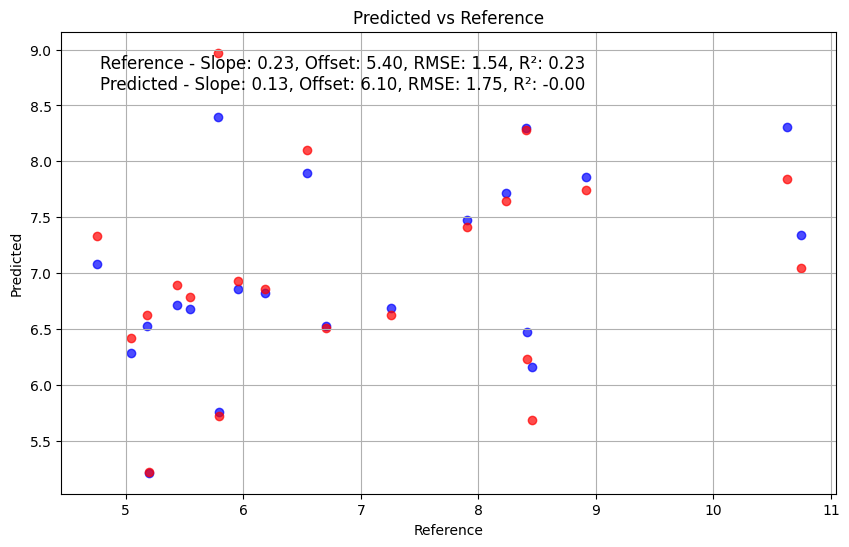

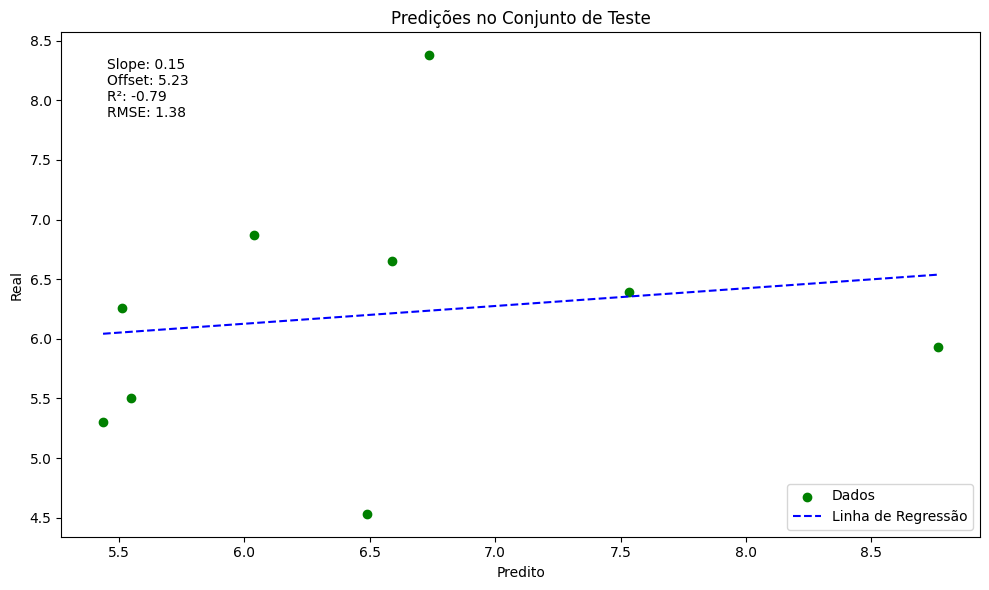

In [16]:
calibration_snv_aac, validation_snv_aac, Y_predict_snv_aac, plot_infos = build_model(df_snv_cal, df_snv_cal['AAC'], df_snv_val, df_snv_val['AAC'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AAC')

Número de componentes: 7


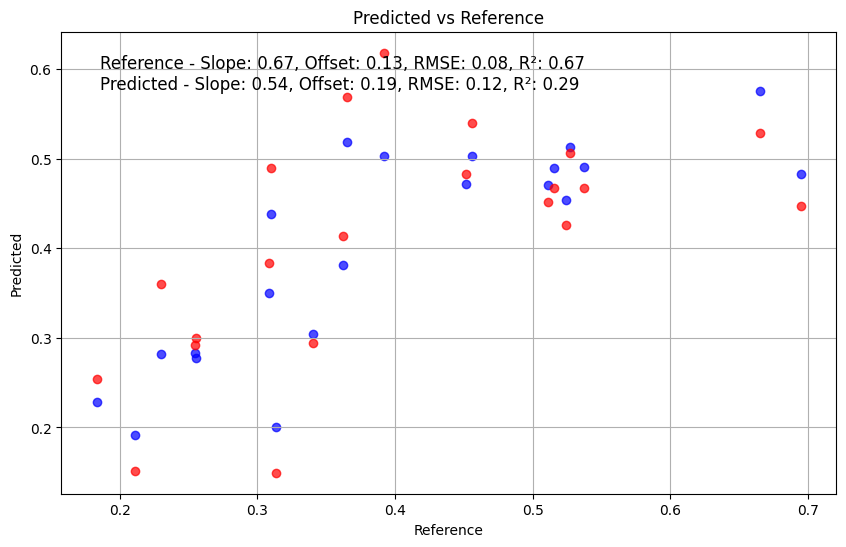

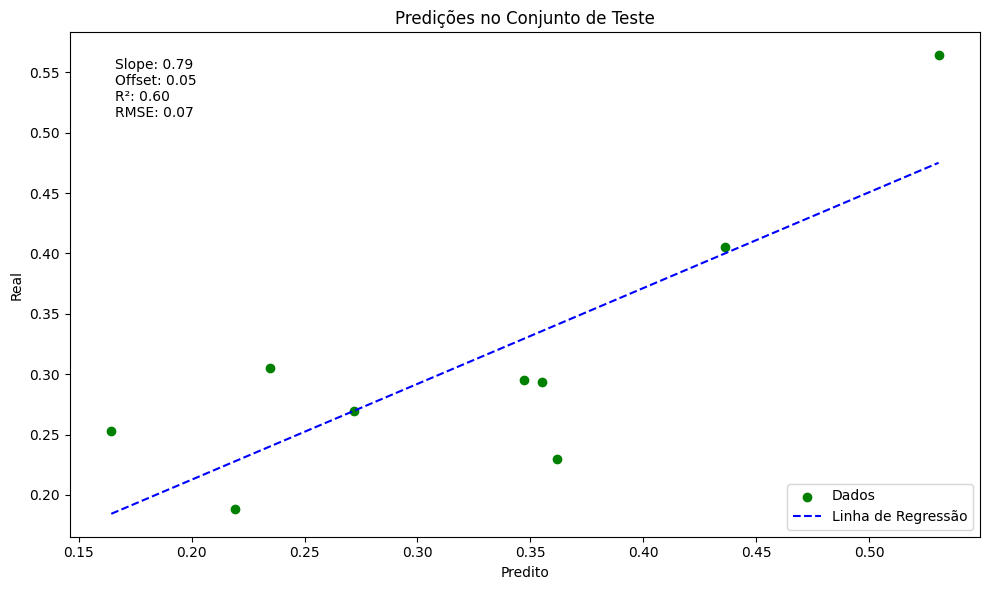

In [17]:
calibration_snv_aac, validation_snv_att, Y_predict_snv_att, plot_infos = build_model(df_snv_cal, df_snv_cal['ACIDEZ'], df_snv_val, df_snv_val['ACIDEZ'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'ACIDEZ')

Número de componentes: 5


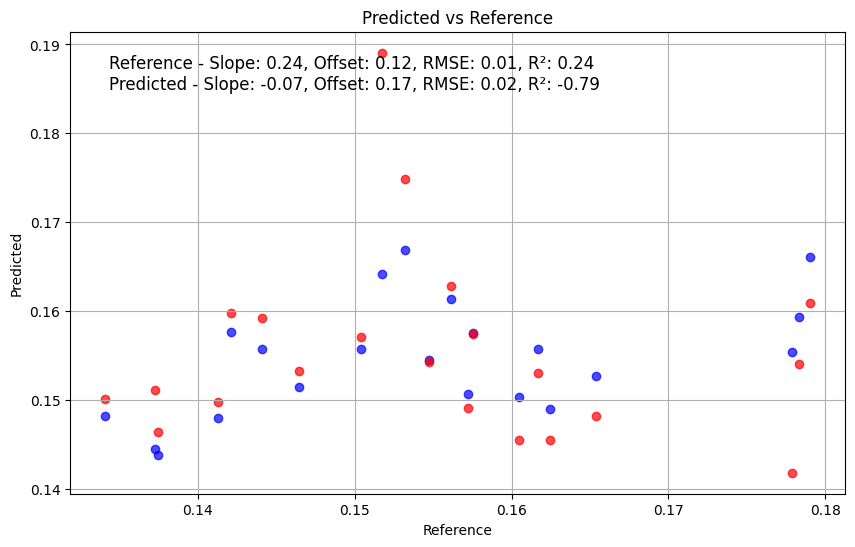

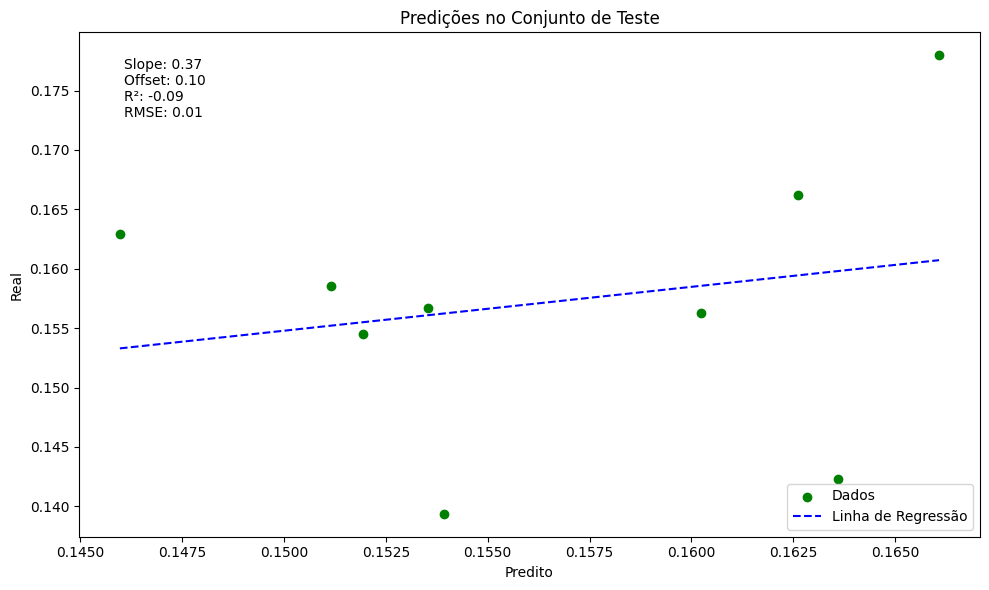

In [18]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['MASSA SECA'], df_snv_val, df_snv_val['MASSA SECA'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'MASSA SECA')

In [19]:
plot_infos_snv.to_excel('plot_infos_pcr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.328058,1.550463,8.138494,0.328058
1,BRIX,Predição,-0.474388,2.296686,11.274391,0.077109
2,BRIX,Validação,-1.344603,1.707755,7.606398,0.479925
3,FIRMEZA,Referência,0.859914,16.130393,8.331127,0.859914
4,FIRMEZA,Predição,0.480292,31.068991,14.870201,0.717460
5,FIRMEZA,Validação,0.667277,20.177956,1.973680,0.745384
6,AAC,Referência,0.229171,1.536637,5.398820,0.229171
7,AAC,Predição,-0.004756,1.754376,6.098343,0.127836
8,AAC,Validação,-0.788662,1.379397,5.232870,0.148909
9,ACIDEZ,Referência,0.668416,0.081783,0.132783,0.668416


Número de componentes: 7


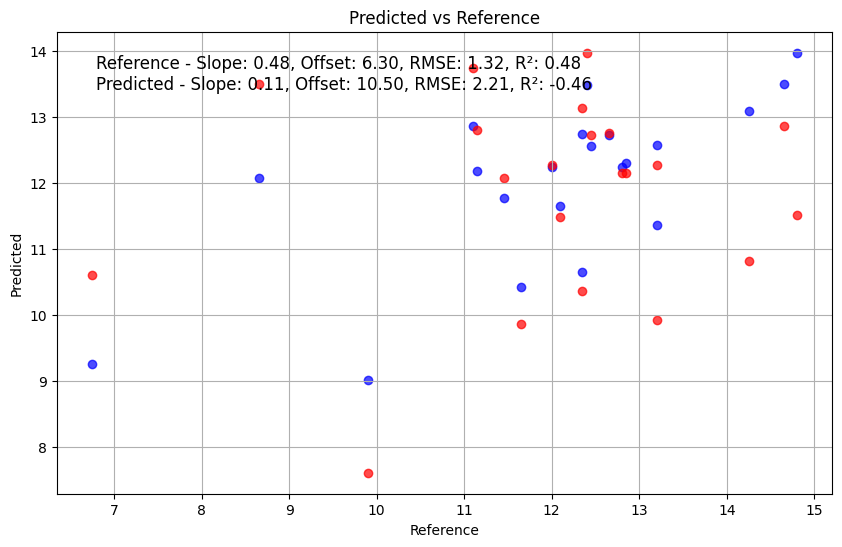

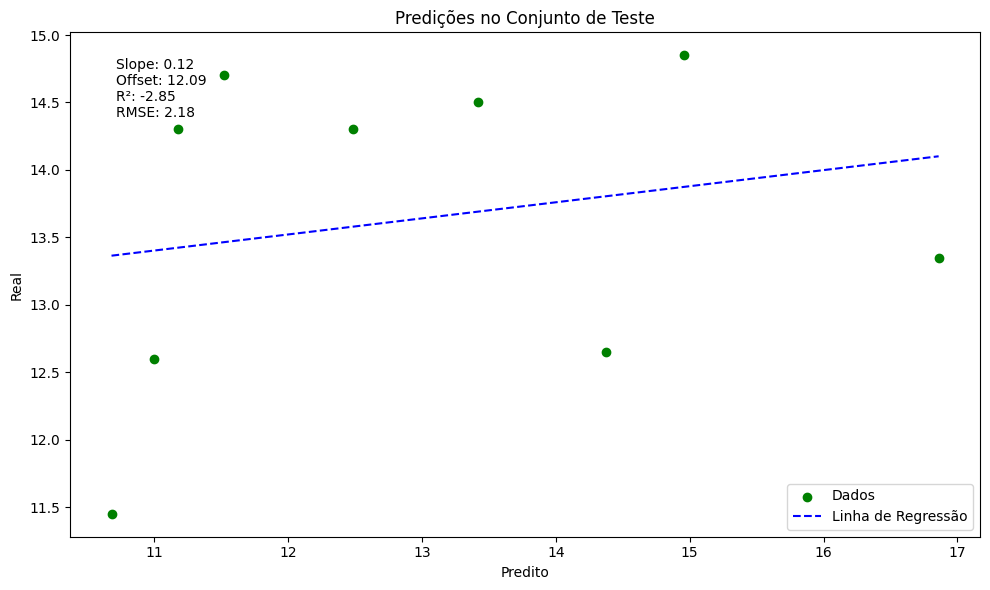

In [20]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['BRIX'], df_sg_val, df_sg_val['BRIX'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'BRIX')

Número de componentes: 9


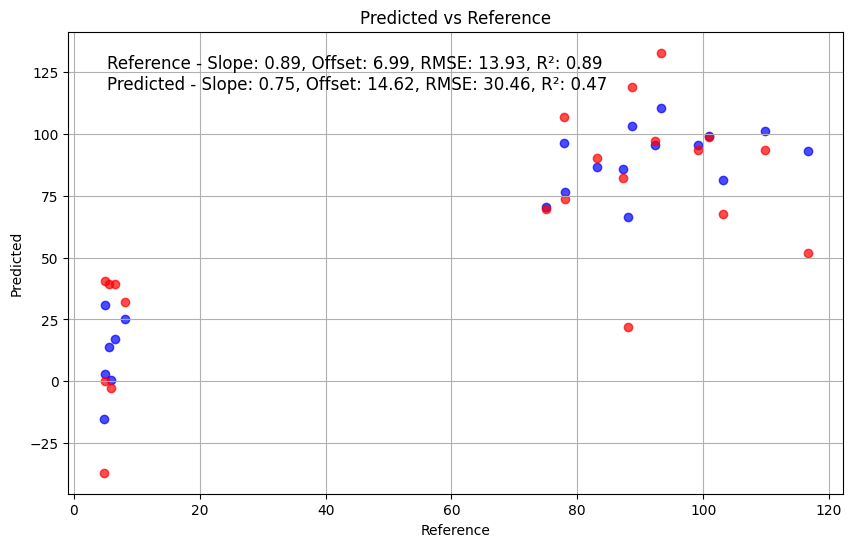

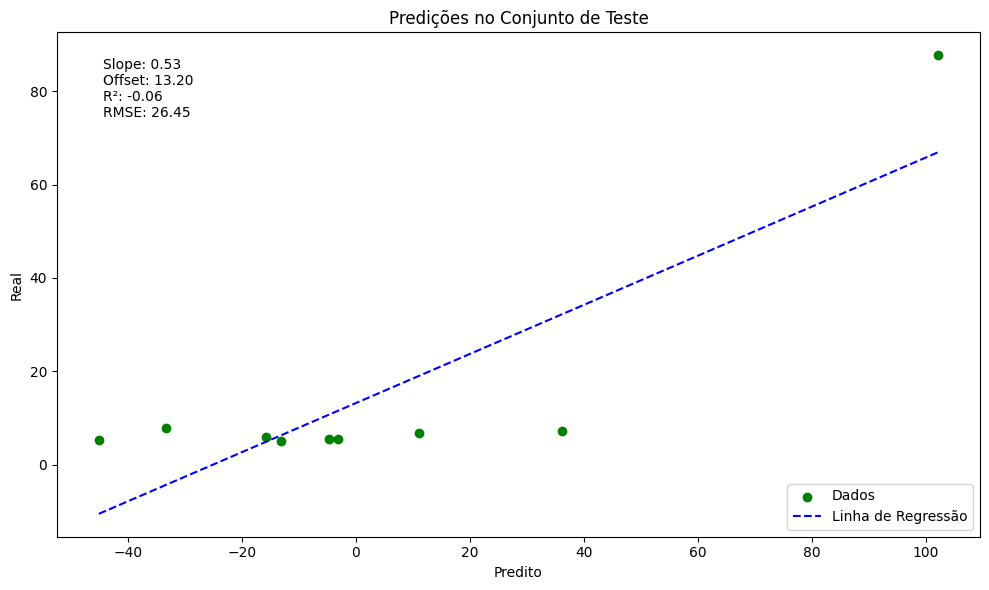

In [21]:
calibration_sg_firmeza, validation_sg_firmeza, Y_predict_sg_firmeza, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMEZA'], df_sg_val, df_sg_val['FIRMEZA'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMEZA')

Número de componentes: 2


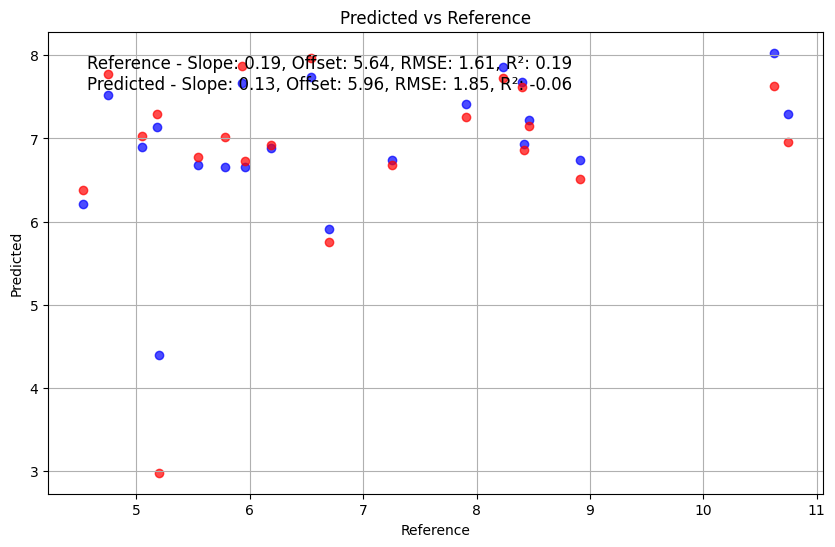

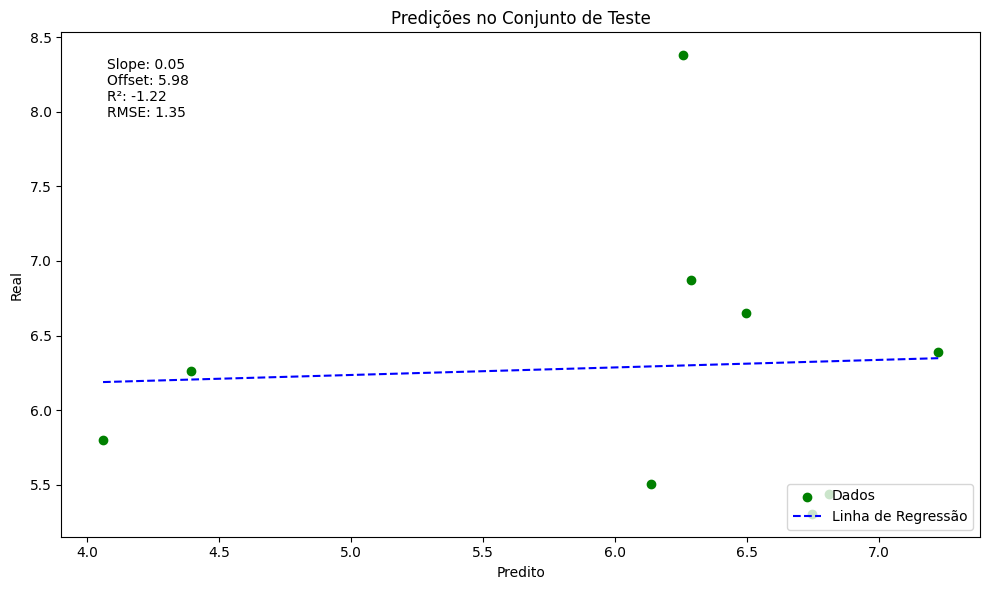

In [22]:
calibration_sg_aac, validation_sg_aac, Y_predict_sg_aac, plot_infos = build_model(df_sg_cal, df_sg_cal['AAC'], df_sg_val, df_sg_val['AAC'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AAC')

Número de componentes: 7


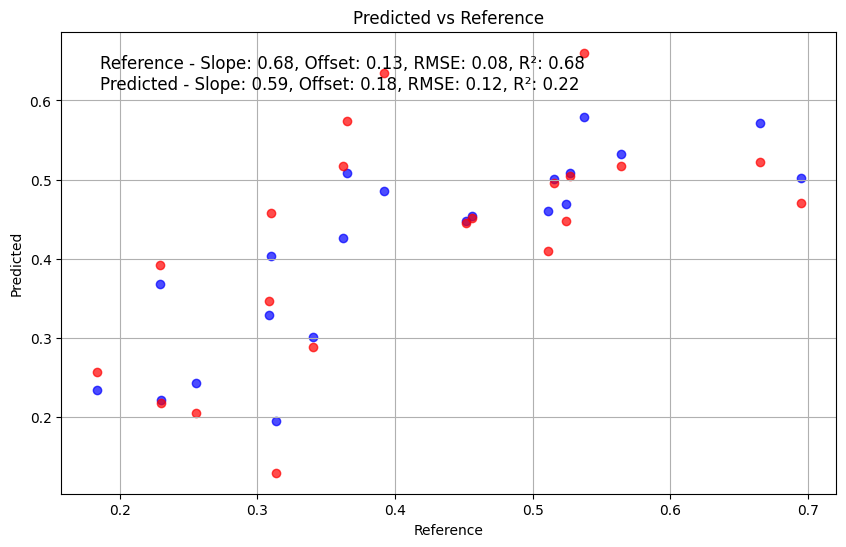

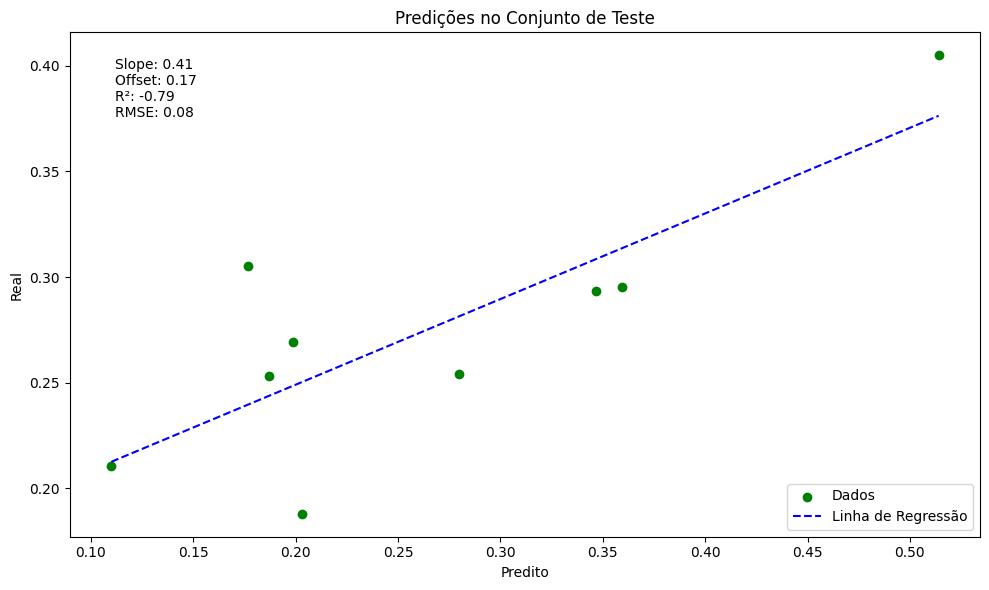

In [23]:
calibration_sg_att, validation_sg_att, Y_predict_sg_att, plot_infos = build_model(df_sg_cal, df_sg_cal['ACIDEZ'], df_sg_val, df_sg_val['ACIDEZ'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'ACIDEZ')

Número de componentes: 4


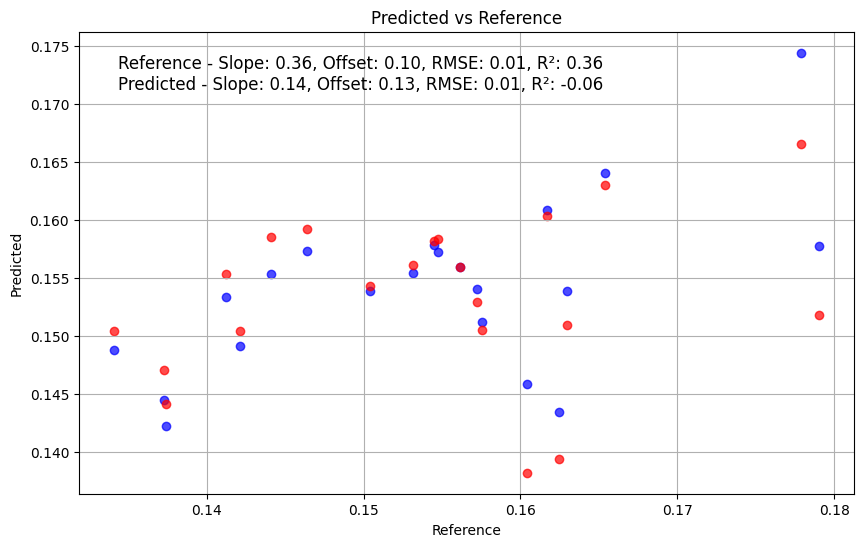

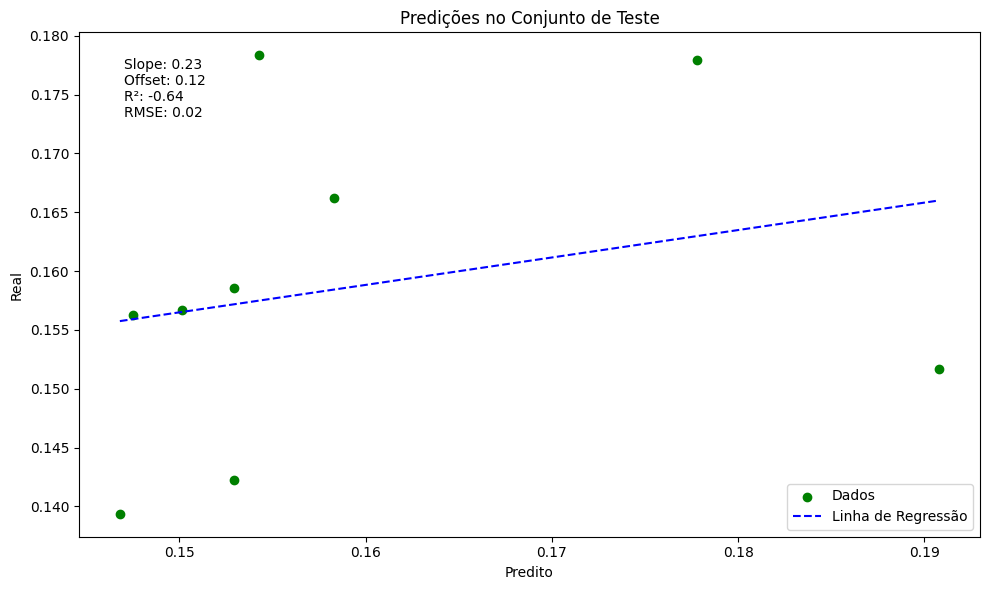

In [24]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['MASSA SECA'], df_sg_val, df_sg_val['MASSA SECA'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'MASSA SECA')

In [25]:
plot_infos_sg.to_excel('plot_infos_pcr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.476685,1.323923,6.297218,0.476685
1,BRIX,Predição,-0.461827,2.212734,10.503367,0.111097
2,BRIX,Validação,-2.845883,2.181822,12.090219,0.119258
3,FIRMEZA,Referência,0.889968,13.926457,6.990265,0.889968
4,FIRMEZA,Predição,0.473548,30.462097,14.618072,0.751287
5,FIRMEZA,Validação,-0.063738,26.450153,13.198974,0.525750
6,AAC,Referência,0.190787,1.614594,5.637970,0.190787
7,AAC,Predição,-0.058786,1.846869,5.961912,0.134568
8,AAC,Validação,-1.221895,1.350693,5.982942,0.050589
9,ACIDEZ,Referência,0.675916,0.080243,0.134845,0.675916


Número de componentes: 5


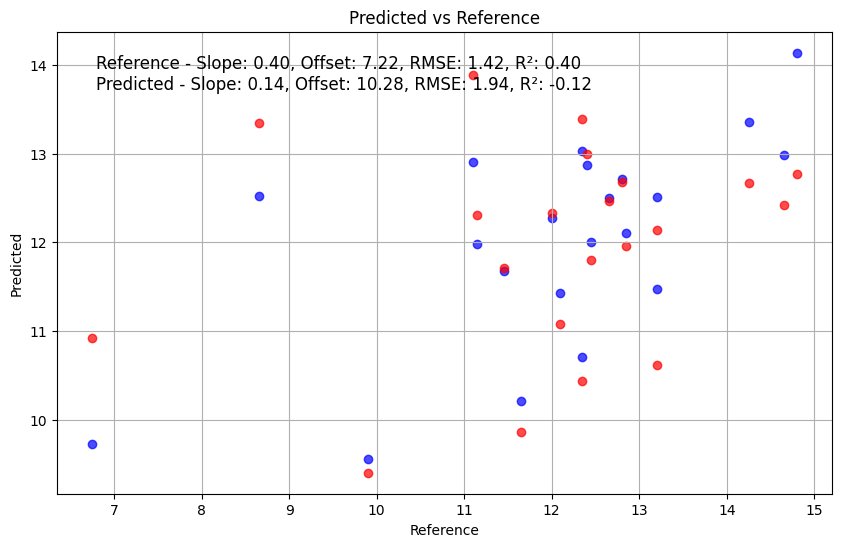

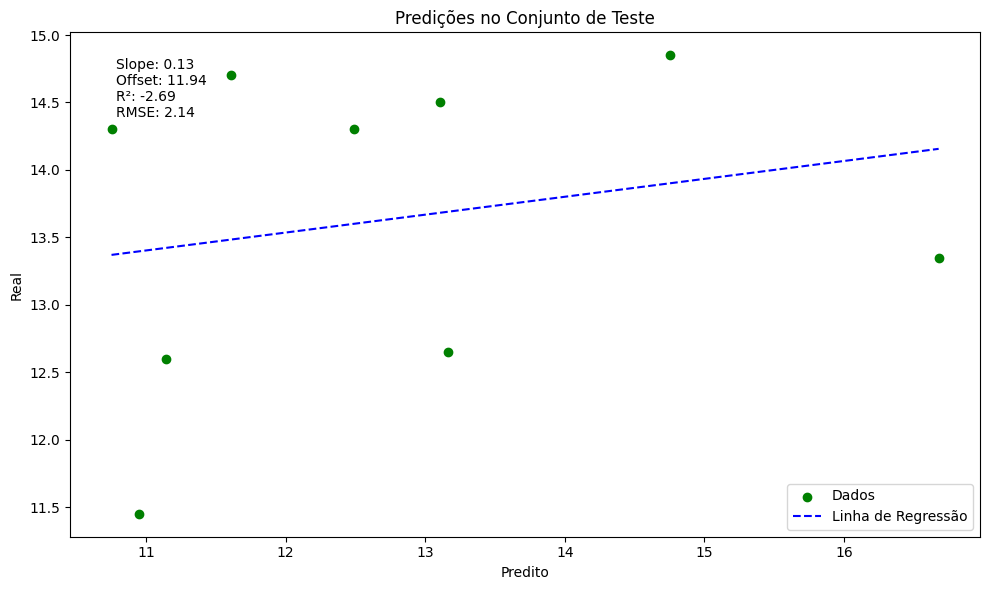

In [26]:
calibration_raw_sst, validation_raw_sst, Y_predict_raw_sst, plot_infos = build_model(df_raw_cal, df_raw_cal['BRIX'], df_raw_val, df_raw_val['BRIX'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'BRIX')

Número de componentes: 4


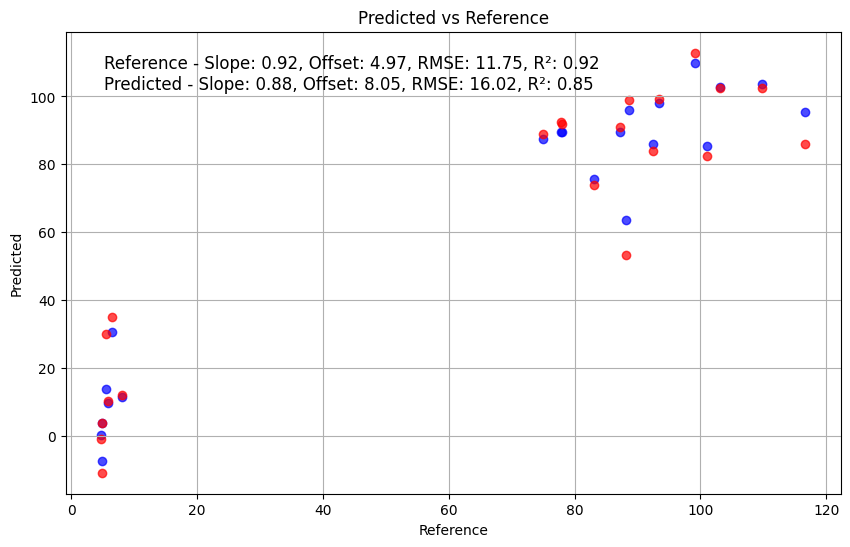

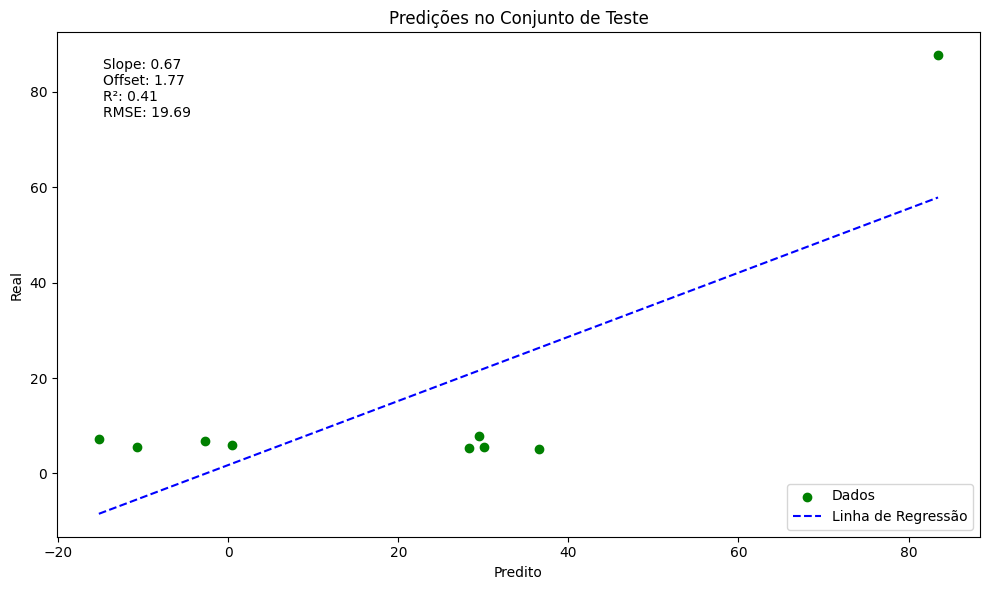

In [27]:
calibration_raw_firmeza, validation_raw_firmeza, Y_predict_raw_firmeza, plot_infos = build_model(df_raw_cal, df_raw_cal['FIRMEZA'], df_raw_val, df_raw_val['FIRMEZA'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'FIRMEZA')

Número de componentes: 3


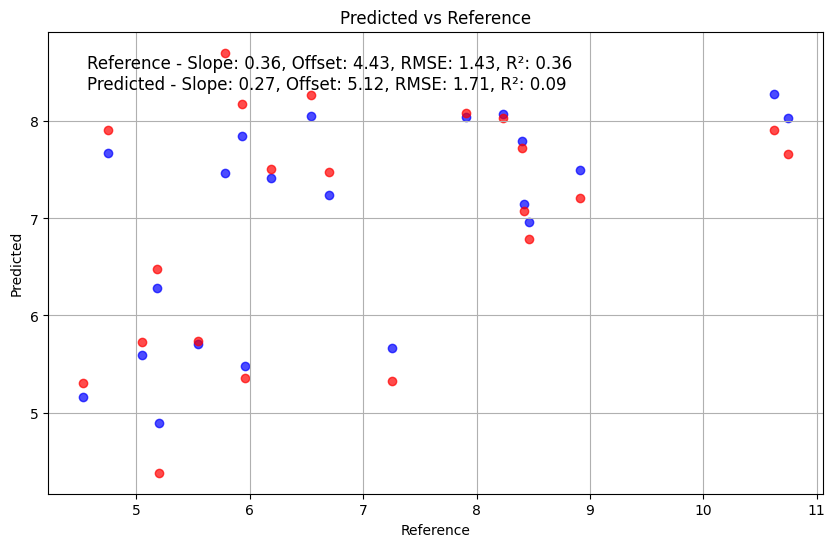

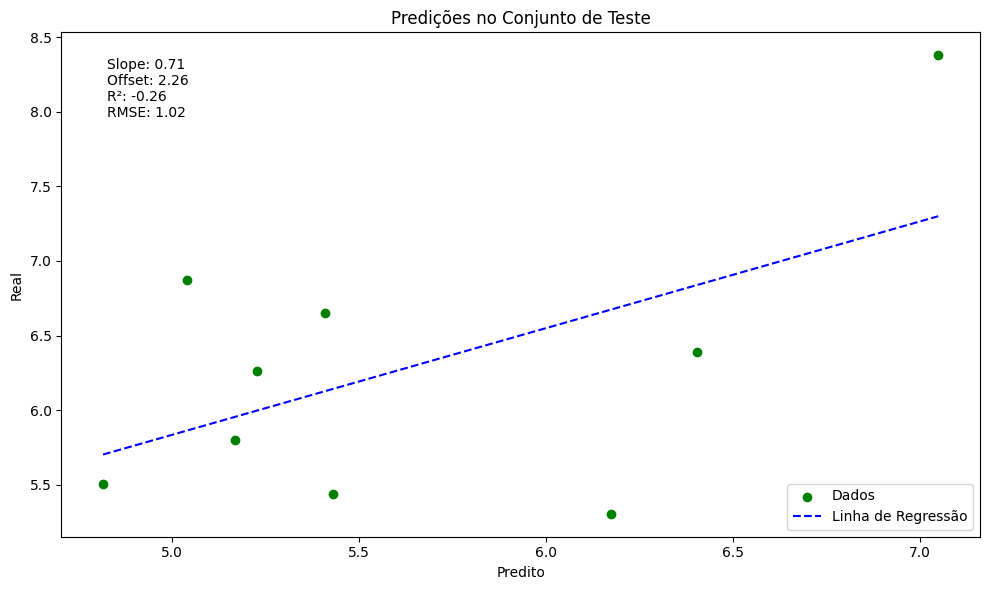

In [28]:
calibration_raw_aac, validation_raw_aac, Y_predict_raw_aac, plot_infos = build_model(df_raw_cal, df_raw_cal['AAC'], df_raw_val, df_raw_val['AAC'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'AAC')

Número de componentes: 9


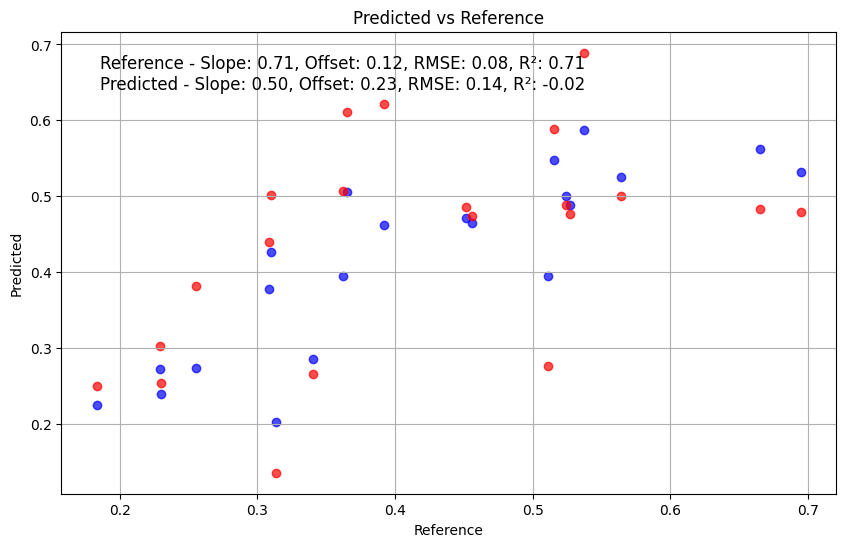

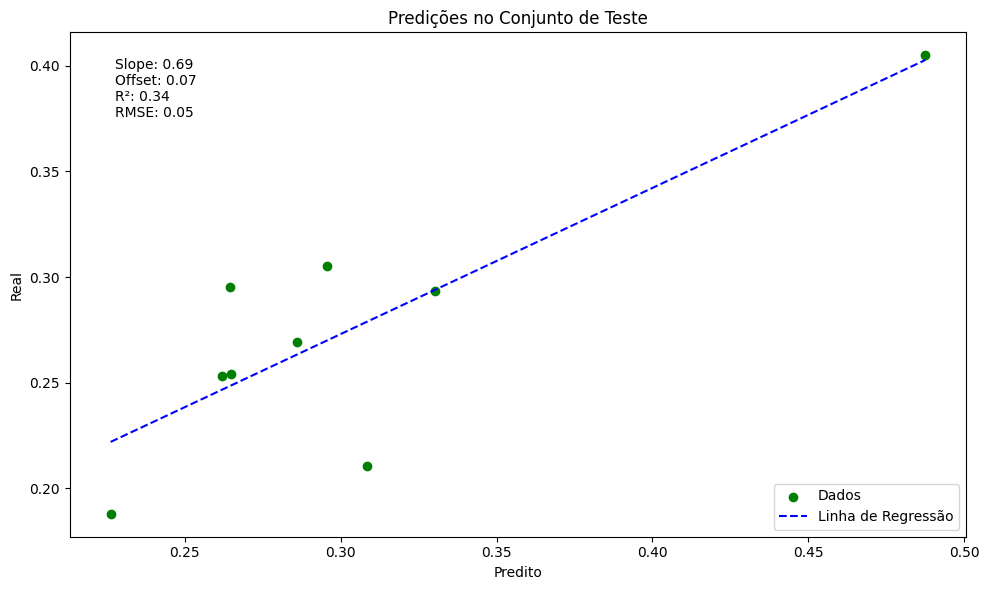

In [29]:
calibration_raw_att, validation_raw_att, Y_predict_raw_att, plot_infos = build_model(df_raw_cal, df_raw_cal['ACIDEZ'], df_raw_val, df_raw_val['ACIDEZ'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'ACIDEZ')

Número de componentes: 5


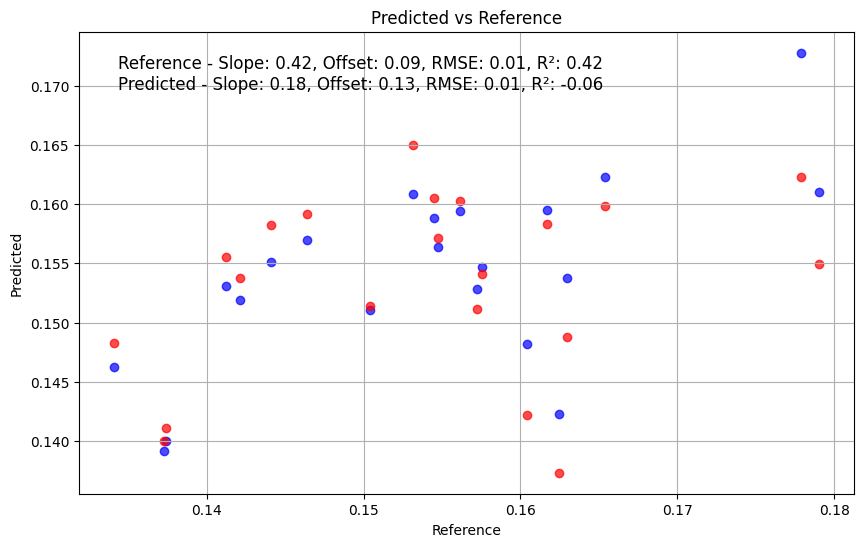

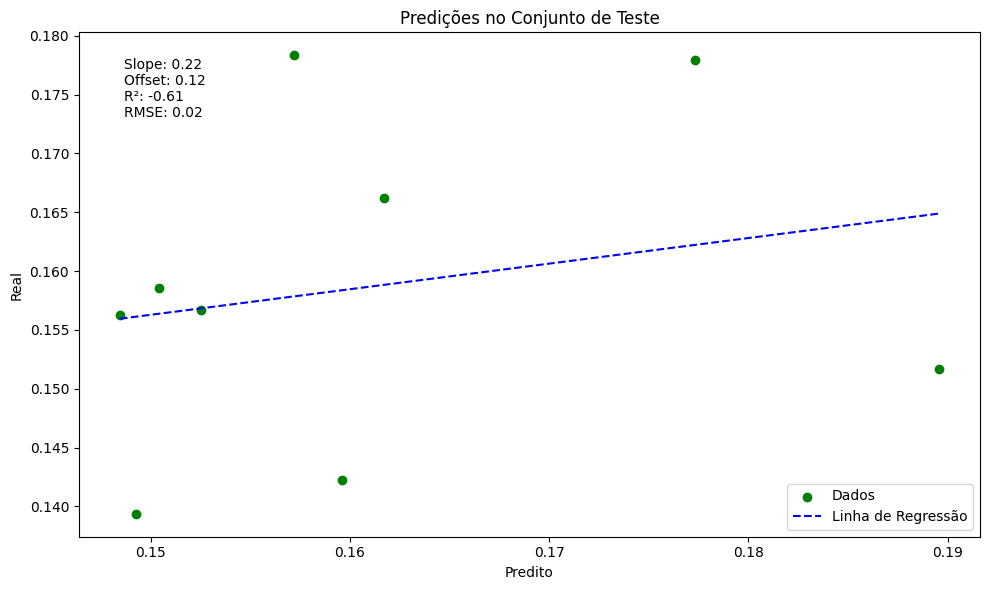

In [30]:
calibration_raw_ubs, validation_raw_ubs, Y_predict_raw_ubs, plot_infos = build_model(df_raw_cal, df_raw_cal['MASSA SECA'], df_raw_val, df_raw_val['MASSA SECA'])

plot_infos_raw = add_plot_infos(plot_infos_raw, plot_infos, 'MASSA SECA')

In [31]:
plot_infos_raw.to_excel('plot_infos_pcr_raw.xlsx', index=False)
plot_infos_raw

,Attribute,Y,R²,RMSE,Offset,Slope
0,BRIX,Referência,0.399612,1.418069,7.224671,0.399612
1,BRIX,Predição,-0.123126,1.939526,10.280647,0.139688
2,BRIX,Validação,-2.685061,2.135717,11.942718,0.132714
3,FIRMEZA,Referência,0.921717,11.746672,4.973270,0.921717
4,FIRMEZA,Predição,0.854436,16.017961,8.048935,0.876778
5,FIRMEZA,Validação,0.410235,19.694752,1.770260,0.672222
6,AAC,Referência,0.364432,1.430912,4.428149,0.364432
7,AAC,Predição,0.093506,1.708891,5.118659,0.269076
8,AAC,Validação,-0.264281,1.018865,2.259590,0.714930
9,ACIDEZ,Referência,0.707742,0.076201,0.121603,0.707742
